In [ ]:
# for Colab
!pip install botorch

In [8]:
import torch
import botorch
import gpytorch

from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.fit import fit_gpytorch_mll
from botorch.models.gp_regression import SingleTaskGP


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.double # double == float64

# isn't this easier?
# https://github.com/pytorch/botorch/discussions/1444
torch.set_default_dtype(dtype)

# torch.set_default_device(device) # similarly

import numpy as np
import matplotlib.pyplot as plt

from predict_EI_simple import calculate_EI_GP, GaussainProcessRandomDataset
from utils import get_uniform_randint_generator, get_param_value


In [5]:
def plot_gp_posterior(ax, posterior, test_x, train_x, train_y, color, name=None):
    lower, upper = posterior.mvn.confidence_region()
    mean = posterior.mean.squeeze().cpu().numpy()
    lower = lower.squeeze().cpu().numpy()
    upper = upper.squeeze().cpu().numpy()

    train_x = train_x.squeeze().cpu().numpy()
    train_y = train_y.squeeze().cpu().numpy()
    test_x = test_x.squeeze().cpu().numpy()

    extension = '' if name is None else f' {name}'

    # Plot training points as black stars
    ax.plot(train_x, train_y, f'{color}*', label=f'Observed Data{extension}')
    # Plot posterior means as blue line
    ax.plot(test_x, mean, color, label=f'Mean{extension}')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x, lower, upper, color=color, alpha=0.5, label=f'Confidence{extension}')


/Users/aloja/opt/anaconda3/lib/python3.9/site-packages/botorch/models/utils/assorted.py:194: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1708025540001/work/aten/src/ATen/native/ReduceOps.cpp:1760.)
  Ymean, Ystd = torch.mean(Y, dim=-2), torch.std(Y, dim=-2)


True: l=-0.509, $\sigma^2$=8.94
Fitted: l=-0.509, $\sigma^2$=8.94


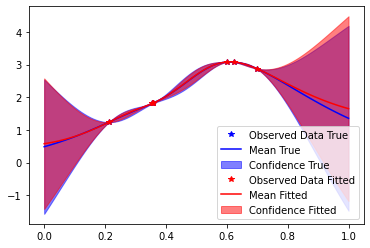

In [41]:
# randint_gen = get_uniform_randint_generator(4, 20)
# dataset = GaussainProcessRandomDataset(
#     dimension=1, n_datapoints_random_gen=randint_gen, observation_noise=False,
#     device=device)

OBSERVATION_NOISE = False

dataset = GaussainProcessRandomDataset(
    dimension=1, n_datapoints=7, observation_noise=OBSERVATION_NOISE,
    device=device)

x_values, y_values, random_model, model = next(dataset)


true_lengthscale = random_model.covar_module.base_kernel.lengthscale.squeeze().numpy()
true_outputscale = random_model.covar_module.outputscale.squeeze().numpy()

print(true_lengthscale)

random_model._clear_cache()

test_x = torch.linspace(0, 1, 100, device=device)

# Get posterior under true model parameters
posterior_true = random_model.posterior(test_x, observation_noise=OBSERVATION_NOISE)

random_model._clear_cache()

# Get posterior by fitting by MAP
mll = ExactMarginalLogLikelihood(random_model.likelihood, random_model)
fit_gpytorch_mll(mll)
posterior_fitted = random_model.posterior(test_x, observation_noise=OBSERVATION_NOISE)

fitted_lengthscale = random_model.covar_module.base_kernel.lengthscale.squeeze().numpy()
fitted_outputscale = random_model.covar_module.outputscale.squeeze().numpy()

print(fitted_lengthscale)

with torch.no_grad():
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))

    description_true = f'True: l={true_lengthscale:.3g}, $\\sigma^2$={true_outputscale:.3g}'
    description_fitted = f'Fitted: l={fitted_lengthscale:.3g}, $\\sigma^2$={fitted_outputscale:.3g}'
    print(description_true)
    print(description_fitted)
    
    plot_gp_posterior(ax, posterior_true, test_x, x_values, y_values, 'b', name='True')
    plot_gp_posterior(ax, posterior_fitted, test_x, x_values, y_values, 'r', name='Fitted')

    ax.legend()